<a href="https://colab.research.google.com/github/louis-sanna-eki/learning-llm/blob/master/Tokenizer_Bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Intro

In this notebook, we explore the compression ratios achieved by the [GPT tokenizer](https://github.com/openai/tiktoken) across the languages of the European Union. A higher ratio indicates better model performance.

Our analysis reveals a significant bias toward English, achieving a compression ratio of 4.99, compared to an average of 2.99 for other languages.

Generally, countries with larger populations and those using the same alphabet as English tend to have higher compression ratios. For example, Greek has a notably low ratio of 2.05.

We have utilized the translations of the [AI Act](https://artificialintelligenceact.eu/the-act/) as our dataset to compute these compression ratios.

This notebook was inspired by the insightful video from Andrej Karpathy, ["Let's Build the GPT Tokenizer"](https://www.youtube.com/watch?v=zduSFxRajkE&ab_channel=AndrejKarpathy).


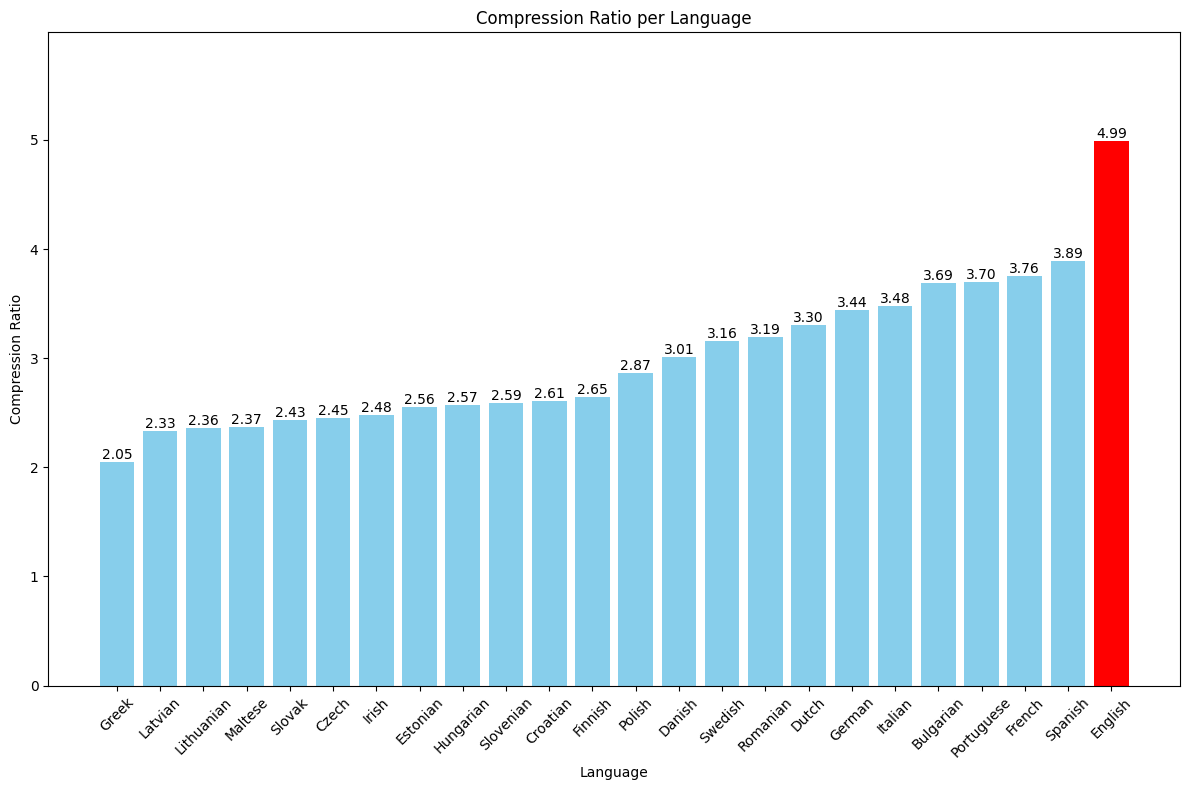

### Setup

In [1]:
!pip install tiktoken google-cloud-storage pymupdf matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 21.8 MB/s eta 0:00:00


### Compute compression

In [2]:
TEXT = "hello world!!!"

In [3]:
utf_tokens = TEXT.encode("utf-8") # raw bytes
utf_tokens = list(map(int, utf_tokens)) # convert to a list of integers in range 0..255 for convenience
print(utf_tokens)

[104, 101, 108, 108, 111, 32, 119, 111, 114, 108, 100, 33, 33, 33]


In [4]:
import tiktoken

# GPT-4
enc = tiktoken.get_encoding("cl100k_base")
gpt_tokens = enc.encode(TEXT)
print(gpt_tokens)

[15339, 1917, 12340]


In [5]:
print(f"compression ratio: {len(utf_tokens) / len(gpt_tokens):.2f}")

compression ratio: 4.67


### Compute compression by language

From the website [Artificial Intelligence Act](https://artificialintelligenceact.eu/the-act/), we can access the AI Act in all the official languages of the European Union. The documents are available in a publicly accessible Google Cloud Storage bucket named 'ai-act-documents'.

In [6]:
BUCKET_NAME = "ai-act-documents"
CODE_TO_LANGUAGE = {
    "BG": "Bulgarian",
    "CS": "Czech",  # CS is an older code for Czech;
    "CZ": "Czech",
    "DA": "Danish",
    "DE": "German",
    "EL": "Greek",  # EL refers to the Greek name 'Ellinika'
    "EN": "English",
    "ES": "Spanish",
    "ET": "Estonian",
    "FI": "Finnish",
    "FR": "French",
    "GA": "Irish",  # Gaelic
    "HR": "Croatian",
    "HU": "Hungarian",
    "IT": "Italian",
    "LT": "Lithuanian",
    "LV": "Latvian",
    "MT": "Maltese",
    "NL": "Dutch",
    "PL": "Polish",
    "PT": "Portuguese",
    "RO": "Romanian",
    "SK": "Slovak",
    "SL": "Slovenian",
    "SV": "Swedish"
}

In [7]:
import google

google.colab.auth.authenticate_user()

In [22]:
from google.cloud import storage
import fitz  # PyMuPDF
import tiktoken

gpt4_encoding = tiktoken.get_encoding("cl100k_base")
gpt4o_encoding = tiktoken.get_encoding("o200k_base")

def fetch_text_from_pdf(pdf_blob):
    """Extracts text from a given PDF blob."""
    pdf_file_stream = pdf_blob.download_as_bytes()
    document = fitz.open(stream=pdf_file_stream, filetype="pdf")
    text = ""
    for page in document:
        text += page.get_text()
    return text

def compute_compression_ratio(text, encoding=gpt4_encoding):
    """Compute the compression ratio for the given text."""
    gpt_tokens = encoding.encode(text)
    utf_tokens = text.encode("utf-8", text)
    utf_tokens = list(map(int, utf_tokens))
    return len(utf_tokens) / len(gpt_tokens) if len(gpt_tokens) > 0 else float('inf')  # Prevent division by zero

client = storage.Client()
bucket = client.bucket(BUCKET_NAME)
blobs = bucket.list_blobs()

results = []

for blob in blobs:
    if blob.name.endswith(".pdf"):
        print(f"Processing: {blob.name}")
        text = fetch_text_from_pdf(blob)
        gpt4_compression_ratio = compute_compression_ratio(text, encoding=gpt4_encoding)
        gpt4o_compression_ratio = compute_compression_ratio(text, encoding=gpt4o_encoding)
        language_code = blob.name[-6:-4]  # Extract language code from filename
        language = CODE_TO_LANGUAGE.get(language_code, "Unknown Language")  # Get language from map
        results.append({
            "file": blob.name,
            "gpt4_compression_ratio": gpt4_compression_ratio,
            "gpt4o_compression_ratio": gpt4o_compression_ratio,
            "language": language
        })
        print(f"Compression ratio for {language} of GPT-4o encoding: {gpt4o_compression_ratio:.2f}")

Processing: TA-9-2024-0138_BG.pdf
Compression ratio for Bulgarian of GPT-4o encoding: 5.55
Processing: TA-9-2024-0138_CS.pdf
Compression ratio for Czech of GPT-4o encoding: 3.36
Processing: TA-9-2024-0138_DA.pdf
Compression ratio for Danish of GPT-4o encoding: 3.52
Processing: TA-9-2024-0138_DE.pdf
Compression ratio for German of GPT-4o encoding: 4.38
Processing: TA-9-2024-0138_EL.pdf
Compression ratio for Greek of GPT-4o encoding: 5.08
Processing: TA-9-2024-0138_EN.pdf
Compression ratio for English of GPT-4o encoding: 5.01
Processing: TA-9-2024-0138_ES.pdf
Compression ratio for Spanish of GPT-4o encoding: 4.59
Processing: TA-9-2024-0138_ET.pdf
Compression ratio for Estonian of GPT-4o encoding: 3.24
Processing: TA-9-2024-0138_FI.pdf
Compression ratio for Finnish of GPT-4o encoding: 3.42
Processing: TA-9-2024-0138_FR.pdf
Compression ratio for French of GPT-4o encoding: 4.45
Processing: TA-9-2024-0138_GA.pdf
Compression ratio for Irish of GPT-4o encoding: 3.16
Processing: TA-9-2024-0138_

In [17]:
ratios = [result['gpt4o_compression_ratio'] for result in results]
sum(ratios) / len(ratios)

3.8059425696463047

### Vizualisation

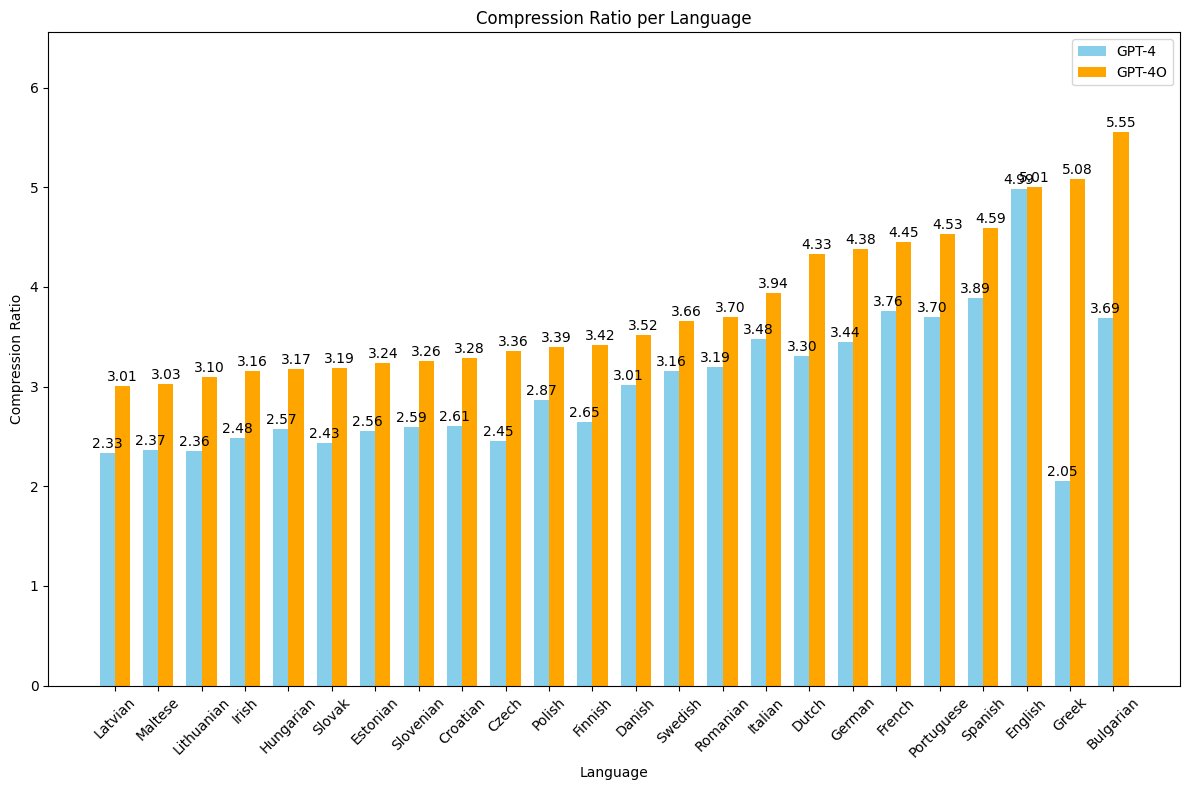

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Sort results by gpt4_compression_ratio
sorted_results = sorted(results, key=lambda x: x['gpt4o_compression_ratio'])

# Extract data
languages = [result['language'] for result in sorted_results]
gpt4_ratios = [result['gpt4_compression_ratio'] for result in sorted_results]
gpt4o_ratios = [result['gpt4o_compression_ratio'] for result in sorted_results]

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.35  # Width of the bars

# Set positions for the bars
index = np.arange(len(languages))

# Plot bars
bar1 = ax.bar(index, gpt4_ratios, bar_width, label='GPT-4', color='skyblue')
bar2 = ax.bar(index + bar_width, gpt4o_ratios, bar_width, label='GPT-4O', color='orange')

# Add labels, title, and legend
ax.set_xlabel('Language')
ax.set_ylabel('Compression Ratio')
ax.set_title('Compression Ratio per Language')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(languages, rotation=45)
ax.legend()

# Add text labels on top of bars
for i, (ratio1, ratio2) in enumerate(zip(gpt4_ratios, gpt4o_ratios)):
    ax.text(i, ratio1 + 0.02, f'{ratio1:.2f}', ha='center', va='bottom')
    ax.text(i + bar_width, ratio2 + 0.02, f'{ratio2:.2f}', ha='center', va='bottom')

# Adjust layout
plt.ylim(0, max(max(gpt4_ratios), max(gpt4o_ratios)) + 1)  # Set y-axis to start at 0 and adjust max to give some space above the highest bar
plt.tight_layout()
plt.show()
